Hopping off the Julia hype train... at least for homework. Crazy TTFP, and for this length of problem set it's just not worth that overhead.

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Quadrature

### Problem 1.

The midpoint rule is given by:
$$ \int_{x_i}^{x_{i+1}} f(x) dx \approx h f\left(x_i + \frac{h}{2}\right)$$
$$ \int_{a}^{b} f(x) dx \approx \sum_{i=0}^{n-1} h f\left(x_i + \frac{h}{2}\right) = \sum_{i=0}^{n-1} h f\left(\frac{x_i + x_{i+1}}{2}\right) $$

where $h = x_{i+1} - x_{i}$ is the width of the range between the two datapoints $x_i$ and $x_{i+1}$. With equally spaced points, $x_0 = a$, $x_{n-1} = b$, and $h = \frac{b - a}{n}$. A ''single panel'' is solving one of these integrations for one little rectangle, while the ''composite panel'' is all of these rectangles for the whole range.

Now, we start our error analysis by taking a Taylor approximation about the midpoint $y_i \equiv x_i+\frac{h}{2}$:
$$ f(x) \approx f(y_i) + (x-y_i)f'(x-y_i) + \frac{1}{2}(x-y_i)^2f''(x-y_i) + \cdots$$
We'll stop at that second term, and use an equal sign rather than approximately equal for simplicity. Now the integral is:
\begin{align*} 
    \int_{x_i}^{x_{i+1}} f(x) dx &= \int_{x_i}^{x_{i+1}} \left[f(y_i) + (x-y_i)f'(x-y_i) + \frac{1}{2}(x-y_i)^2f''(x-y_i)\right] dx \\
    &= \int_{x_i}^{x_{i+1}} f(y_i) dx + \int_{x_i}^{x_{i+1}} (x-y_i)f'(x-y_i) dx
    + \frac{1}{2}\int_{x_i}^{x_{i+1}} (x-y_i)^2f''(x-y_i) dx
\end{align*}

Importantly, the middle term will go to zero, as the points $x_1$ and $x_{i+1}$ are symmetric about $y_1$. Using the midpoint rule, this becomes:
\begin{align*} 
    \int_{x_i}^{x_{i+1}} f(x) dx &= h f(y_i) + \frac{1}{2}\int_{x_i}^{x_{i+1}} (x-y_i)^2f''(x-y_i) dx
\end{align*}
That last integral will become some term with power $h^3$ (as the integral of something like $h^2$), and all higher order terms will be smaller, so we'll package them together as:
$$\int_{x_i}^{x_{i+1}} f(x) dx \approx h f(y_i) + O(h^3) $$

This completes the single panel case, giving an error on the order of $h^3$. For the composite case, we simple sum from $i=0$ to $i=n-1$, which has an overall effect of multiplying by $n = \frac{b-a}{h}$, so the overall error is on the order of $h^2$ for the entire integral.

We'll now move on to the implementation for $f(x) = \frac{1}{\sqrt{1+x^2}}$. Analytically evaluating this integral, we start with the trig substitution $x = \tan\theta$ (meaning $dx = \sec^2\theta$ and $\sqrt{1+x^2} = \sec\theta$), later using the substitution $u = \sec\theta+\tan\theta$:
\begin{align*}
    \int_0^1 \frac{dx}{\sqrt{1 + x^2}} &= \int \sec\theta d\theta = \int \frac{du}{u} = \ln|u| = \ln\left|\sec\theta + \tan\theta\right|\\ &= \left[\ln\left|\sqrt{1+x^2} + x\right|\right]_0^{1} = \ln\left|\frac{\sqrt{1+1}+1}{\sqrt{1+0}+0}\right| = \ln\left(\sqrt{2} + 1\right) \approx 0.881374
\end{align*}

In [42]:
def f(x):
    return 1 / np.sqrt(1 + x**2)

In [43]:
def midpoint_int(f, a, b, n):
    h = (b-a)/n
    integral = 0
    x = a
    for _ in range(n):
        integral += h * f(x + h/2)
        x += h
    return integral

In [44]:
true_val = np.log(np.sqrt(2) + 1)
midpoint_val = midpoint_int(f, 0, 1, 51)

print("True integral value:",true_val)
print("Midpoint value:     ",midpoint_val)

True integral value: 0.8813735870195429
Midpoint value:      0.8813792508085248


And remember that we expect error for the whole integral to be on the order of $h^2$ **or better**:

In [45]:
def order_of_mag(a):
    return np.floor(np.log10(np.abs(a)))

h = 1/51
print("Order of h^2:", order_of_mag(h**2))
print("Order of error:", order_of_mag(true_val - midpoint_val))

Order of h^2: -4.0
Order of error: -6.0


Here we see the actual error was better than the predicted worst case of $h^2$, being a term of order $10^{-6}$, while $h^2$ is on the order $10^{-4}$.

### Problem 2.

#### 2a. We start by importing the functions for Simpson and adaptive integration from the textbook.

In [46]:
def simpson(f,a,b,n):
    h = (b-a)/(n-1)
    xs = a + np.arange(n)*h
    cs = 2*np.ones(n)
    cs[1::2] = 4; cs[0] = 1; cs[-1] = 1
    contribs = cs*f(xs)
    
    return (h/3)*np.sum(contribs)

In [47]:
def adaptive(f,a,b,kmax = 20,tol = 1e-12):
    denom = 15
    n = 2
    val = simpson(f,a,b,n)
    for k in range(kmax):
        nprime = 2*n-1
        valprime = simpson(f,a,b,nprime)
        err = abs(valprime-val) / denom
        err /= abs(valprime)
        if err < tol:
            break
        n, val = nprime, valprime
    else:
        valprime = None
    return nprime, valprime

In [48]:
def glasser_integrand(t):
    return np.sin(t * np.sin(t))

In [49]:
def G(x):
    n, val = adaptive(glasser_integrand, 0, x)
    return n, val

In [50]:
x_range = np.linspace(0.001,20,500)
G_range = np.zeros(len(x_range))
n_range = np.zeros(len(x_range))
for i in range(len(x_range)):
    n_range[i], G_range[i] = G(x_range[i])

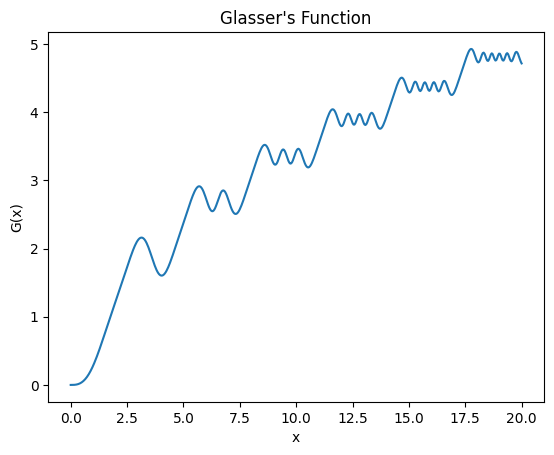

In [51]:
plt.plot(x_range, G_range)
plt.title("Glasser's Function")
plt.ylabel("G(x)")
plt.xlabel("x")
plt.show()

#### 2b. Required $n$

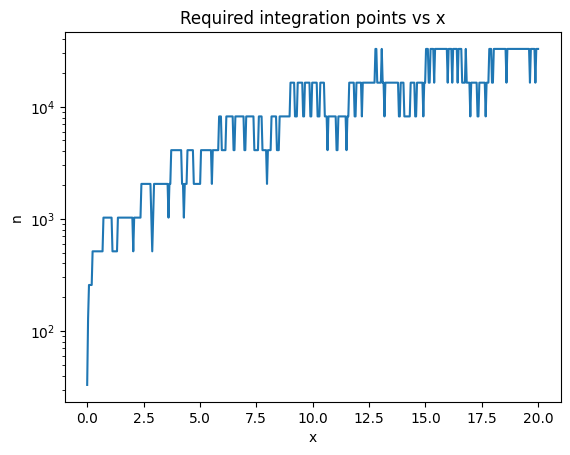

In [52]:
plt.plot(x_range, n_range)
plt.title("Required integration points vs x")
plt.yscale("log")
plt.ylabel("n")
plt.xlabel("x")
plt.show()

#### 2c. Find minima

We find minima by setting the first derivative equal to 0 and ensuring the second derivative is positive (concave up). Analytically, using the fundamental theorem of calculus, we find these derivatives as:
\begin{align*}
    G'(x) &= \sin(x\sin x) \\
    G''(x) &= \cos(x \sin x)[\sin x + x\cos x]
\end{align*}
I'll start by plotting $G'(x)$

In [53]:
def G_prime(x):
    return np.sin(x*np.sin(x))

def G_dblprime(x):
    return np.cos(x*np.sin(x)) * (np.sin(x) + x*np.cos(x))

In [54]:
x_range = np.linspace(0.001,20,500)
G_prime_range = np.zeros(len(x_range))
G_dblprime_range = np.zeros(len(x_range))
for i in range(len(x_range)):
    G_prime_range[i] = G_prime(x_range[i])
    G_dblprime_range[i] = G_dblprime(x_range[i])

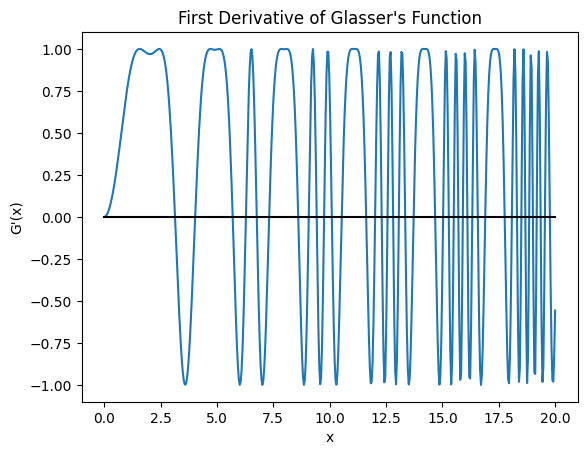

In [55]:
plt.plot(x_range, G_prime_range)
plt.plot([0,20],[0,0], color="black")
plt.title("First Derivative of Glasser's Function")
plt.ylabel("G'(x)")
plt.xlabel("x")
plt.show()

This is the function we want to find the roots of. We'll modify a version of the bisection algorithm to do this, iteratively finding the 

In [56]:
def bisection(f,x0,x1,kmax=200,tol=1.e-8):
    f0 = f(x0)
    for k in range(1,kmax):
        x2 = (x0+x1)/2
        f2 = f(x2)
        
        if f0*f2 < 0:
            x1 = x2
        else:
            x0, f0 = x2, f2

        x2new = (x0+x1)/2
        xdiff = abs(x2new-x2)
            
        if abs(xdiff/x2new) < tol:
            break
        else:
            x2new = None

    return x2new

In [57]:
found_extrema = np.array([])

x0 = 2
x1 = 3.5

# lowkey proud of this one
while len(found_extrema) < 41:
    new_extremum = bisection(G_prime, x0, x1)
    found_extrema = np.append(found_extrema, new_extremum)

    x0 = x1 + 0.01 # move initial point to a little bit past old end point
    x1 = x0 + 0.01 # move end point to a little bit past that
    sign_a = np.sign(G_prime(x0))  # sign of G' at the point we want to bisect starting at
    sign_b = sign_a                # before finding next point, signs will be the same
    while sign_a == sign_b:
        sign_b = np.sign(G_prime(x1))
        x1 += 0.01

    if x1 > 20:
        break

print(found_extrema)

[ 3.14159266  4.03423624  5.69936159  6.28318533  6.76604877  7.31613231
  8.60636436  9.07112289  9.42477804  9.75275002 10.09647436 10.53277223
 11.6204205  12.01612557 12.30827229 12.56637068 12.81406307 13.06794765
 13.35015889 13.72356334 14.68049912 15.03019477 15.28431713 15.50391809
 15.70796328 15.90677063 16.10864966 16.32347409 16.56886813 16.90080427
 17.7647306  18.08113749 18.30881994 18.50309114 18.6805786  18.84955598
 19.01552872 19.18324936 19.35805405 19.54777479 19.76793454]


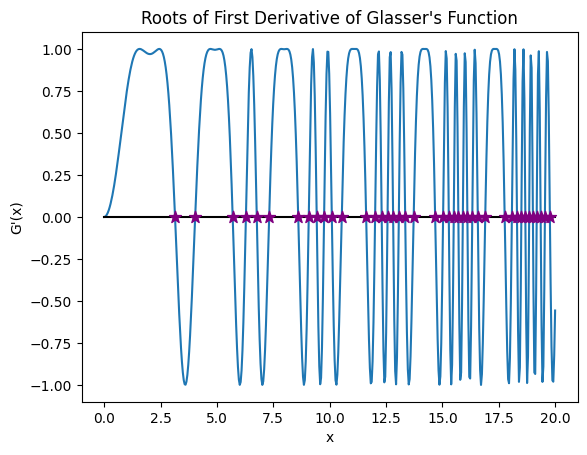

In [58]:
plt.plot(x_range, G_prime_range)
plt.plot([0,20],[0,0], color="black")
plt.scatter(found_extrema, np.zeros(len(found_extrema)), color="purple", marker="*", zorder=10, s=80)
plt.title("Roots of First Derivative of Glasser's Function")
plt.ylabel("G'(x)")
plt.xlabel("x")
plt.show()

Now all we need to do to identify whether these are minima or maxima is to only keep the ones where the second derivative of $G$ is positive, since that corresponds to being concave up.

In [59]:
G_minima = [found_extremum for found_extremum in found_extrema if G_dblprime(found_extremum) > 0]
print(G_minima)

[np.float64(4.034236239194859), np.float64(6.283185333013475), np.float64(7.316132314205089), np.float64(9.071122887134432), np.float64(9.752750015258654), np.float64(10.532772233486027), np.float64(12.016125569343387), np.float64(12.566370682716176), np.float64(13.067947654723916), np.float64(13.723563337325835), np.float64(15.030194773673763), np.float64(15.503918089866382), np.float64(15.90677063465092), np.float64(16.32347408771494), np.float64(16.900804266929498), np.float64(18.08113749027258), np.float64(18.503091135025155), np.float64(18.8495559787752), np.float64(19.183249359131093), np.float64(19.547774791717814)]


In [82]:
G_at_minima = np.zeros(len(G_minima))
for i in range(len(G_minima)):
    _, g = G(G_minima[i])
    G_at_minima[i] = g

In [83]:
# Due to some numerical weirdness (I suspect), the 8th minimum found (call it x8) gave G(x8) = 0 
# I could not figure out why (the minimum was right, but the value for G messed up), so i just set it to the same
# value as the one before it, which visually looks pretty alright
G_at_minima[7] = G_at_minima[6]

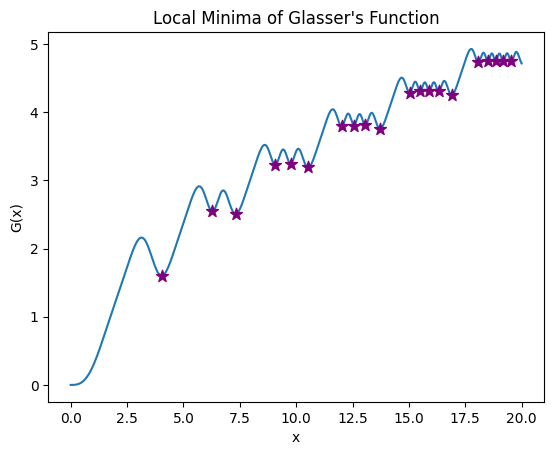

In [84]:
plt.plot(x_range, G_range)
plt.title("Local Minima of Glasser's Function")
plt.scatter(G_minima, G_at_minima, color="purple", marker="*", zorder=10, s=80)
plt.ylabel("G(x)")
plt.xlabel("x")
plt.show()

### Problem 3.

Gauss-Hermite quadrature is used to approximate integrals in the following form:
$$ \int_{-\infty}^{\infty} e^{-x^2} f(x) dx \approx \sum_{j=1}^{n}c_j f(x_j), $$
using the following expression for $c_j$:
$$ c_j = \frac{2^{n+1}n!\sqrt{\pi}}{[H'_n(x_j)]^2}$$
where $H_n'(x_j)$ is the first derivative of the $n^\text{th}$ Hermite polynomial evaluated at $x_j$. That derivative can be given by this recurrence relation:
$$ H_n'(x) = 2n H_{n-1}(x)$$

Note also that the $x_j$ are the roots of Hermite polynomials

In [63]:
from scipy.special import eval_hermite

def H_prime(n, x):
    if n == 0:
        return np.zeros_like(x)
    return 2 * n * eval_hermite(n - 1, x)

In [64]:
from scipy.special import factorial 
def gauss_hermite(f, x_pts):
    integral = 0
    n = len(x_pts)
    
    c = (2**(n+1) * factorial(n) * np.sqrt(np.pi)) / (H_prime(n, x_pts))**2
    integral = np.sum(c * f(x_pts))
    return integral

Now we need a routine to find the points $x_j$, which are the $n$ roots of the Hermite polynomial $H_n(x)$

In [65]:
from numpy.polynomial.hermite import hermgauss
n = 10
x_pts, _ = hermgauss(n)

We'll test this on the function $f(x) = 1$, where we know the Gaussian integral evaluates to:
$$ \int_{-\infty}^{\infty} e^{-x^2} dx = \sqrt{\pi} \approx 1.772454$$

In [66]:
gauss_hermite(lambda f : 1, x_pts)

np.float64(1.7724538509055159)

### Problem 4.

Letting $u =\sqrt{x}$ and thus $x = u^2$ and $dx = 2udu$ below, we see:
\begin{align*}
    \int_{0}^{\infty} \frac{x^2 + x}{\sqrt{x}}e^{-x} dx = \int_{0}^{\infty} \frac{u^4 + u^2}{u} e^{-u^2} \left(2u\right) du = \int_{-\infty}^{\infty} \left(u^4 + u^2\right)e^{-u^2} du
\end{align*}
where the even-ness of the integrand at the end means that $2\int_{0}^{\infty} f(u) du = \int_{-\infty}^{\infty} f(u)du$

In [67]:
def f(u):
    return u**4 + u**2

In [68]:
n = 10
x_pts, _ = hermgauss(n)

gauss_hermite(f, x_pts)

np.float64(2.215567313631893)

### Problem 5.

In [69]:
def trapezoid(f,a,b,n):
    h = (b-a)/(n-1)
    xs = a + np.arange(n)*h
    cs = np.ones(n); cs[0] = 0.5; cs[-1] = 0.5
    contribs = cs*f(xs)
    
    return h*np.sum(contribs)


In [70]:
def h(x):
    return np.sqrt(x) * np.cos(x)

In [71]:
n_arr = np.array([])
int_arr = np.array([])
for m in range(50):
    n = m+2
    I = trapezoid(h, 0, np.pi, n)

    n_arr = np.append(n_arr, n)
    int_arr = np.append(int_arr, I)

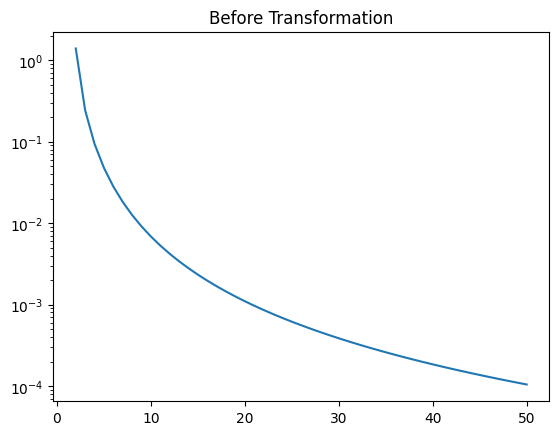

In [72]:
int_change_arr = np.zeros(len(int_arr) - 1)
for i in range(len(int_change_arr)):
    int_change_arr[i] = int_arr[i+1] - int_arr[i]

plt.plot(n_arr[:-1], int_change_arr)
plt.yscale("log")
plt.title("Before Transformation")
plt.show()

Applying the transformation $u = \sqrt{x}$ so $x = u^2$ and $dx = 2u du$, our integral becomes
$$ I = 2\int_{0}^{\sqrt{\pi}} u^2 \cos(u^2) du$$

In [73]:
def p(x):
    return 2 * (x**2 * np.cos(x**2))

In [74]:
n_arr = np.array([])
int_arr = np.array([])
for m in range(50):
    n = m+2
    I = trapezoid(p, 0, np.sqrt(np.pi), n)

    n_arr = np.append(n_arr, n)
    int_arr = np.append(int_arr, I)

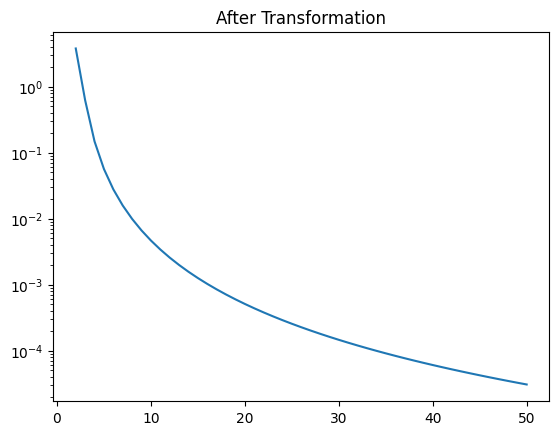

In [75]:
int_change_arr = np.zeros(len(int_arr) - 1)
for i in range(len(int_change_arr)):
    int_change_arr[i] = int_arr[i+1] - int_arr[i]

plt.plot(n_arr[:-1], int_change_arr)
plt.yscale("log")
plt.title("After Transformation")
plt.show()

I'm honestly not sure what I'm supposed to be seeing here... they look like they have the exact same convergence behavior.

### Problem 6.

We're trying to evaluate the following integral:

$$ N = A(k_BT)^{\alpha+1} \int_0^{\infty} \frac{x^\alpha}{e^{x-w} \pm 1} dx$$

I am going to disagree with the problem statement, and say the easiest way to do this is with Gauss-Laguerre integration. This is for integrals of the form:

$$ \int_0^{\infty} x^\alpha e^{-x} f(x) dx \approx \sum_{j=1}^n c_j f(x_j) $$

where $c_j$ are the weights of and $x_j$ are the roots of the generalized Laguerre polynomials $L_n^{(\alpha)}(x)$.

In this form, the integral we want to evaluate has :

$$ f(x) = A(k_BT)^{\alpha+1} \frac{e^x}{e^{x-w} \pm 1}$$

And we're going to let the constants $A = k_B = T = 1$, just so we can see the patterns we want to see easier without being bogged down by high/low numerical factors.

In [76]:
from scipy.special import roots_genlaguerre

def N(w, n, alpha, particle):
    if particle == "fermion":
        pm1 = 1
    elif particle == "boson":
        pm1 = -1
    else:
        raise ValueError("Please enter 'fermion' or 'boson' for particle.")
    
    x_lag, c_lag = roots_genlaguerre(n, alpha)

    def f(x):
        return np.exp(x) / (np.exp(x-w) + pm1)
    
    integral = np.sum(c_lag * f(x_lag))
    return integral 


In [77]:
fermion_w_arr = np.linspace(-10, 20, 100)
fermion_half_arr = np.zeros(len(fermion_w_arr))
fermion_two_arr = np.zeros(len(fermion_w_arr))

n = 30
i = 0
for w in fermion_w_arr:
    fermion_half_arr[i] = N(fermion_w_arr[i], n, 0.5, "fermion")
    fermion_two_arr[i] = N(fermion_w_arr[i], n, 2, "fermion")

    i += 1

In [78]:
boson_w_arr = np.linspace(-30, 0, 100)
boson_half_arr = np.zeros(len(boson_w_arr))
boson_two_arr = np.zeros(len(boson_w_arr))

i = 0
n = 30
for w in boson_w_arr:
    boson_half_arr[i] = N(boson_w_arr[i], n, 0.5, "boson")
    boson_two_arr[i] = N(boson_w_arr[i], n, 2, "boson")

    i += 1

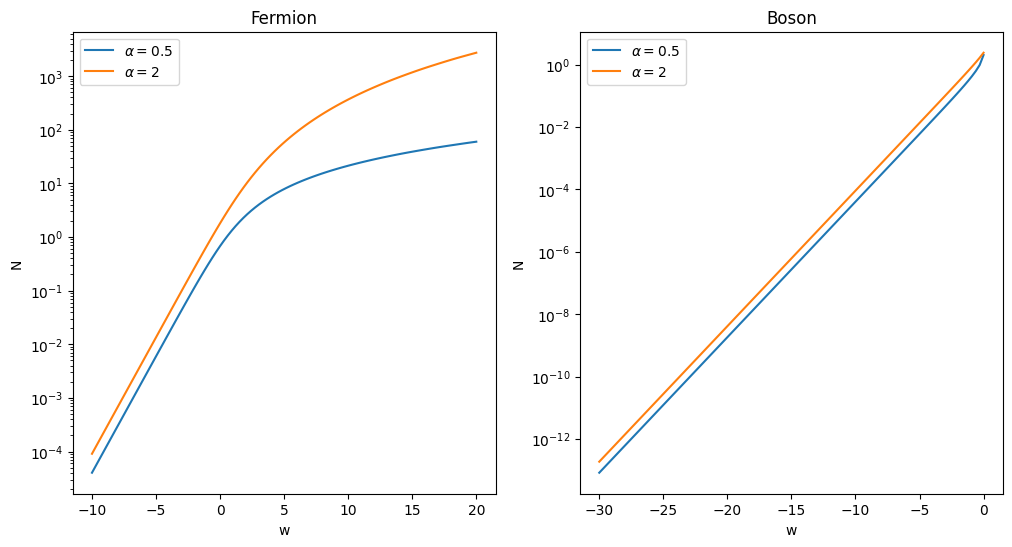

In [79]:
fig, ax = plt.subplots(1,2, figsize =(12,6))

ax[0].plot(fermion_w_arr, fermion_half_arr, label = r"$\alpha = 0.5$")
ax[0].plot(fermion_w_arr, fermion_two_arr, label = r"$\alpha = 2$")
ax[0].set_title("Fermion")
ax[0].set_yscale("log")
ax[0].set_xlabel("w")
ax[0].set_ylabel("N")
ax[0].legend()

ax[1].plot(boson_w_arr, boson_half_arr, label = r"$\alpha = 0.5$")
ax[1].plot(boson_w_arr, boson_two_arr, label = r"$\alpha = 2$")
ax[1].set_title("Boson")
ax[1].set_yscale("log")
ax[1].set_xlabel("w")
ax[1].set_ylabel(rf"N")
ax[1].legend()

plt.show()

# Random Numbers

### Problem 1.

In [142]:
def u(i, u_0, p):
    last_u = u_0
    for _ in range(i+1):
        u = (p*last_u + 7) % 2**32
        last_u = u
    return u / 2**32

In [143]:
even_arr1 = np.array([])
odd_arr1 = np.array([])
for i in range(1000):
    val = u(i, 314159, 2**18 + 1)
    if i % 2 == 0:
        even_arr1 = np.append(even_arr1, val)
    else:
        odd_arr1 = np.append(odd_arr1, val)

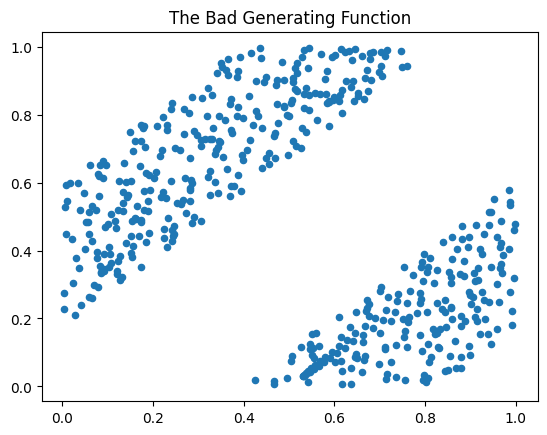

In [144]:
plt.scatter(even_arr1, odd_arr1, s=20)
plt.title("The Bad Generating Function")
plt.show()

In [145]:
even_arr2 = np.array([])
odd_arr2 = np.array([])
for i in range(1000):
    val = u(i, 314159, 1812433253)
    if i % 2 == 0:
        even_arr2 = np.append(even_arr2, val)
    else:
        odd_arr2 = np.append(odd_arr2, val)

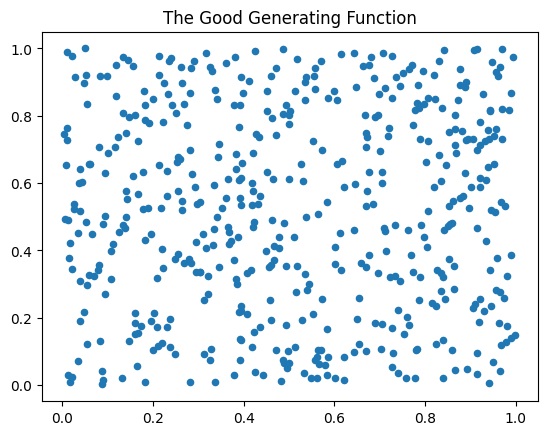

In [146]:
plt.scatter(even_arr2, odd_arr2, s=20)
plt.title("The Good Generating Function")
plt.show()

In [147]:
even_arr3 = np.array([])
odd_arr3 = np.array([])
for i in range(1000):
    val = np.random.random()
    if i % 2 == 0:
        even_arr3 = np.append(even_arr3, val)
    else:
        odd_arr3 = np.append(odd_arr3, val)

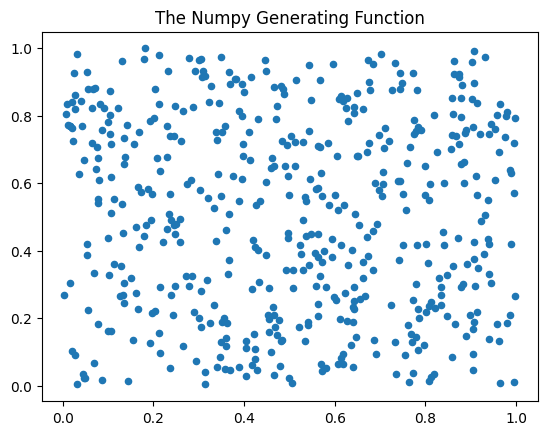

In [148]:
plt.scatter(even_arr3, odd_arr3, s=20)
plt.title("The Numpy Generating Function")
plt.show()

### Problem 2.

$$ \chi^2 = \frac{n_b}{n}\sum_{j=0}^{n_b-1} \left(n_j - \frac{n}{n_b}\right)^2$$

In [ ]:
def chi_square(pts):
    nb = 10
    n = len(pts)

    counting_pts = np.floor(pts*10)  # all values are 0 to 1, this maps them to integers 0 to 9

    _, counts = np.unique(counting_pts, return_counts=True)

    return (nb / n) * np.sum((counts - n / nb)**2)

My laptop was taking a ridiculously long time to run this for $n = 10^5$, so i just changed to $n=10^4$.

In [165]:
n = int(1e4)
arr1 = np.zeros(n)
arr2 = np.zeros(n)
arr3 = np.zeros(n)

for i in range(n):
    val1 = u(i, 314159, 2**18 + 1)
    val2 = u(i, 314159, 1812433253)
    val3 = np.random.random()

    arr1[i] = val1
    arr2[i] = val2
    arr3[i] = val3

In [164]:
print("The Bad One:  ", chi_square(arr1))
print("The Good One: ", chi_square(arr2))
print("The Numpy One:", chi_square(arr3))

The Bad One:   2.45
The Good One:  4.428
The Numpy One: 9.11


### Problem 3.

Starting with the weighting function:

$$ w(x) = \frac{1}{10\pi\left[(x-2.5)^2 + 0.01\right]} $$

the goal is approximating the following integral:

$$ \int_a^b w(x)f(x) dx $$

We start by introducing $g(x) = \int_0^x w(x')dx'$ (notice that if $w(x)$ is a probability density function, then $g(x)$ is a cumulative distribution function), so $g'(x) = w(x)$. We will also use the fact that $x = g^{-1}(g(x))$ by the definition of a function inverse, and the substitution $u = g(x)$:

$$ \int_a^b w(x)f(x) dx = \int_a^b f(x) \frac{dg}{dx} dx = \int_a^b f(g^{-1}(g(x))) \frac{dg}{dx} dx = \int_{g(a)}^{g(b)} f(g^{-1}(u)) du$$
$$= \int_0^{b-a} f(g^{-1}(u)) du \approx \frac{b-a}{n} \sum_{i=0}^{n-1} f(g^{-1}(\mathcal{v}_i))$$

If the points $v_i$ are uniformly distributed from $a$ to $b$, math then tells us that $g^{-1}(v_i)$ are distributed according to $w(x)$.

So, what we need to do is find $g^{-1}$, by first integrating $w$ and then finding the inverse of the result:
\begin{align*}
    g(x) = \int_{0}^{x} w(y) dy &= \frac{1}{10\pi}\int_{0}^{x} \frac{dy}{(y-2.5)^2 + 0.01} \\
    &= \frac{1}{10\pi}\int_{y=0}^{y=x} \frac{du}{u^2 + 1/100} \qquad \text{ for } u = y - \frac{5}{2} \\
    &= \frac{100}{10\pi} \int \frac{du}{(10u)^2 + 1} \\
    &= \frac{1}{\pi} \int \frac{dv}{v^2 + 1} \qquad \text{ for } v = 10u \\
    &= \frac{1}{\pi} \arctan{v} = \left[\frac{1}{\pi} \arctan\left(10\left(y - \frac{5}{2}\right)\right)\right]_{y=0}^{y=x} \\
    &= \frac{1}{\pi} \left[\arctan\left(10x - 25\right) - \arctan(-25)\right] \\
    g(x) &= \frac{1}{\pi} \left[\arctan\left(10x - 25\right) + \arctan(25)\right]
\end{align*}

We then need to find the inverse of $g$, which we do by replacing $g$ in the above equation with $x$ and $x$ with $g^{-1}$, then solving. For ease of writing, I'm going to define $\alpha \equiv \arctan(25)$.

\begin{align*}
    x &= \frac{1}{\pi} \left[\arctan\left(10g^{-1} - 25\right) + \alpha\right] \\
    \pi x - \alpha &= \arctan\left(10g^{-1} - 25\right) \\
    g^{-1}(x) &= \frac{\tan(\pi x - \alpha) + 25}{10}
\end{align*}

As we said before, putting uniformly randomly distibuted $x$ into this function will return functions distributed according to $w(x)$. Pretty cool honestly.

In [166]:
def g_inv(x):
    return (np.tan(np.pi * x - np.arctan(25)) + 25) / 10

In [171]:
n = 10**4
uniform_pts = np.random.random(size=n)

cauchy_pts = g_inv(uniform_pts)

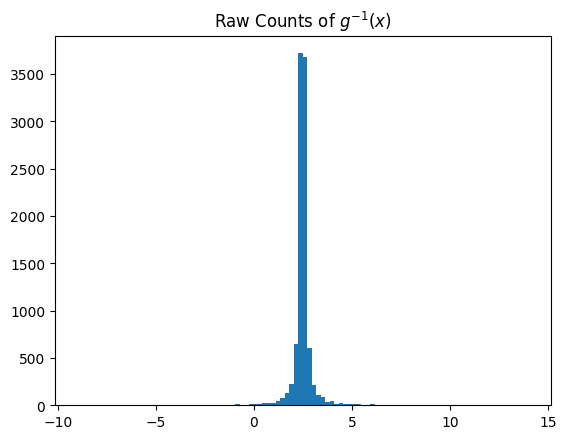

In [186]:
bins = np.linspace(-9,14,101).tolist() # 101 pts = 100 bins, list because the histogram function didn't like the numpy array for some reason
plt.hist(cauchy_pts, bins=bins)
plt.title(r"Raw Counts of $g^{-1}(x)$")
plt.show()

In [187]:
def w(x):
    return (10*np.pi * ((x - 2.5)**2 + 0.01))**-1

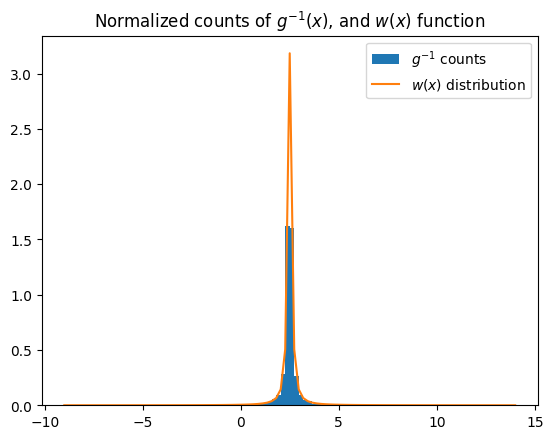

In [190]:
plt.hist(cauchy_pts, bins=bins, density=True, label=r"$g^{-1}$ counts")
plt.plot(bins, w(np.array(bins)), label=r"$w(x)$ distribution")
plt.title(r"Normalized counts of $g^{-1}(x)$, and $w(x)$ function")
plt.legend()
plt.show()

In [197]:
n_list = np.array([1e3, 1e4, 1e5, 1e6, 1e7, 1e8]).astype(int)

In [213]:
i = len(n_list)
for n in n_list:
    uniform_pts = np.random.random(size=n)
    cauchy_pts = g_inv(uniform_pts)
    print(f"n = {n},"," "*i, f"sample mean = {cauchy_pts.mean()}") # i like the spacing trick that was fun to think through how to make happen
    i -= 1

n = 1000,        sample mean = 2.4717057335611727
n = 10000,       sample mean = 1.3756510650214562
n = 100000,      sample mean = 2.390330100848085
n = 1000000,     sample mean = 2.6025259529337257
n = 10000000,    sample mean = 1.7405077328744363
n = 100000000,   sample mean = 2.415223853545642


If we were using a nice function like a normal distribution, we would expect the sample mean to settle towards the true mean of the distribution, but as Google told me, the Cauchy distribution does not have a defined mean or variance. It's a heavy tailed distribution, and the integrals defining those moments do not converge. So we get a sample mean pretty close to the center sometimes, by happenstance, but the heavy tails of the distribution sometimes mean we draw a really really high or a really really low value, and that throws off the mean.

### Problem 4.

The Metropolis-Hastings algorithm allows us to sample from a probability distribution $w(x)$. In this problem, we're letting $w(x) = e^{-x}$, where the integral $\int_0^\infty e^{-x} x^2 dx$ is equivalent to calculating the expectation value of $x^2$ when the $x$ values are samples according to the distribution $e^{-x}$. We will approximate this expectation value with the sample mean of a dataset $\vec{x}$ whose elements are $x_i$, meaning $\bar{x}_i = \frac{1}{N} \sum_{i=0}^{N-1} x_i^2$

I'm going to start by writing out the steps of the algorithm (translated to be for a single-dimensional problem like this, rather than multi-dimensional like in the book), just so I can get them in my head a little better than just reading the book.

0. Start at a random location $x_0$. Doesn't matter where.
1. Start the loop with $x_{i-1}$ (which is $x_0$ the first time), and propose step with $y_i = x_{i-1} + \theta u_i$, where $y_i$ is the proposed next location, $\theta$ is a number controlling the step size, and $u_i$ is a uniformly distributed sample on $[-1,1]$. $\theta$ is chosen such that about 15 to 50 percent of steps are accepted. The equation is literally just "take $x_{i-1}$ and move by some amount either forwards or backwards.
2. Acceptance probability is $\alpha(x_{i-1} \to y_i) = \min\left[1, \frac{w(y_i)}{w(x_i)}\right]$. Notice that we don't need to normalize the $w$ distribution since those normalization constants will cancel out. So we can use probability densities instead of probabilites.
3. Using that acceptance probability, set $x_i = y_i$ if accepted and $x_i = x_{i-1}$ if rejected. In practice, this is done by getting a random sample $s_i$ of a uniform distribution and accepting/rejecting based on whether that is higher or lower than $\alpha(x_i \to y_i)$.
4. Every $n_m$ steps, evaluate $f(x_i)$. We do this every $n_m$ steps instead of every step (called "thinning") to avoid the fact that our Markov-Chain-built $x_i$ is necessarily correlated with $x_{i-1}$.
5. Increment $i$ and return to step 1. Terminate whenever you've generated enough measurement samples (those used in 4) to get the desired variance of the sample mean (or, after a set number of steps). 

In [240]:
# again had to decrease the number of points for runtime reasons
max_n = int(1e6)

f = lambda x: x**2
w = lambda x: np.exp(-x)

f_pts = []

x_i_minus_1 = np.random.random()
theta = 2
accepted = 0
for i in range(max_n):
    y_i = x_i_minus_1 + theta * np.random.uniform(-1, 1)

    if y_i < 0:
        x_i = x_i_minus_1
    else:
        alpha = min(1, w(y_i) / w(x_i_minus_1))
        x_i = y_i if np.random.random() <= alpha else x_i_minus_1
    
    if x_i != x_i_minus_1:
        accepted += 1

    # take every 100th x_i and compute f(x_i), starting after 1000 steps for burn-in
    if i % 100 == 0 and i > 1000:
        f_pts.append(f(x_i))
        #print(f"f(x_{i}) appended")

    x_i_minus_1 = x_i

# for adjusting theta to be in the 0.15 - 0.5 range (started with 2, then 1, then)
print("\% accepted:", 100 * accepted / max_n)

\% accepted: 43.2359


In [241]:
np.array(f_pts).mean()

np.float64(1.9833626335737538)

Now onto the Gauss-Laguerre part. Luckily we've already done this part and more luckily it isn't complicated.

In [244]:
from numpy.polynomial.laguerre import laggauss

x, c = laggauss(2)
print(np.sum(c * f(x)))

2.0


Just to check that those are right, we'll do the integral analytically too.
\begin{align*}
    \int_0^{\infty} e^{-x} x^2 dx &= \left[-e^{-x}\left(x^2 + 2x + 2\right)\right]_0^{\infty} = \left[e^{0}(0 + 0 + 2)\right] - 0 = 2
\end{align*}
Voila. Go Wonderboys.